In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# PyTorch Requirements
import torch
import torch.nn as nn
from torch import Tensor
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from sklearn.preprocessing import StandardScaler

%matplotlib inline

In [2]:
# Load and prepare data
data = pd.read_csv("../../data/cyclohexane.csv", header=0)

# raw data and best sample
X = data.drop("solvent", axis=1)
best_sample = X.iloc[0].to_numpy().reshape(-1, 1)

# We will need to preprocess and scale the data
# Also due to data size, the MSE loss approaches infinity, scaling data improves training time and stability
scaler = StandardScaler()

# First we have a lot of scattering effects on the tail of the spectra, this information is not required
X_trim = X.copy()
X_trim = X.iloc[:, :2901]

# Next standardise the data
# transpose so we do it per sample (like Standard Normal Variate) and transpose again for shape (n_samples, n_features)
X_scaled = scaler.fit_transform(X_trim.T).T

## Visualise data before and after preprocessing

In [3]:
plt.rcParams['font.size'] = 12
xticks = np.linspace(0, X.shape[1]-1, 10, dtype=int)
xlabels = X.columns[xticks].astype(float).astype(int).values

def build_plot():
    fig, ax = plt.subplots(figsize=(8, 4))
    plt.gca().spines['right'].set_color('none')
    plt.gca().spines['top'].set_color('none')
    plt.ylabel("Intensity (a.u)")
    plt.xlabel("Raman Shift (cm$^{-1}$)")
    plt.xlim([-20, 3296])
    plt.xticks(xticks, labels=xlabels)
    plt.grid(False)
    
    return fig

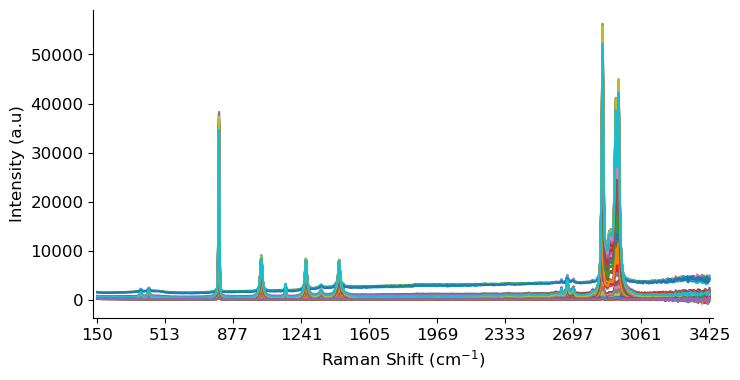

In [4]:
# Raw Spectra
_ = build_plot()
plt.plot(X.T);

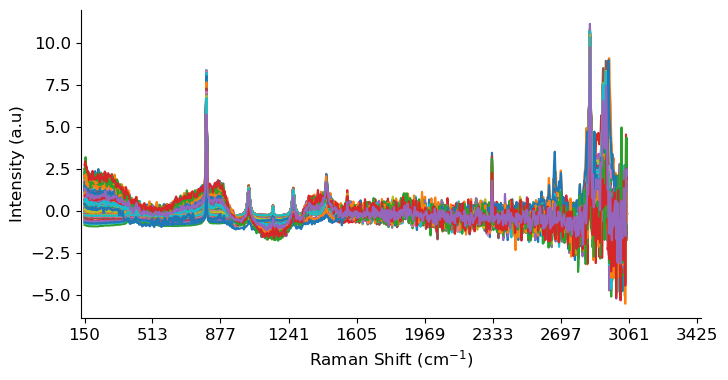

In [5]:
# Standardised spectra
_ = build_plot()
plt.plot(X_scaled.T);

## Define required functions


In [6]:
# First we need a custom Torch tensor Dataset to load in the data
class CyclohexaneDataTensor(Dataset):
    def __init__(self, data_X: Tensor, transform_list=None):
        """
        Initialises object and performs data transformation if desired
        
        Args:
            data_X (array-like):
                Spectral data matrix (NumPy array or PyTorch Tensor).
            transform_list (list):
                List of transformations to apply to data (e.g., normalizing, scaling).

        """

        if not isinstance(data_X, (np.ndarray, Tensor)):
            raise TypeError("data_X must be a NumPy array or PyTorch tensor")
            
        self.X_tensor = torch.as_tensor(data_X, dtype=torch.float32)
        self.transforms = transform_list

    def __getitem__(self, index) -> Tensor:
        x = self.X_tensor[index].clone()

        if self.transforms:
            for transform in self.transforms:
                x = transform(x)
        return x

    def __len__(self) -> int:
        return self.X_tensor.size(0)

# Define our loss as the reconstruction loss (MSE) + the Kullback-Leibler (KL) Divergence
def loss_function(x: Tensor, x_hat: Tensor, mean: Tensor, logvar: Tensor) -> Tensor:
    """
    Computes the loss for the Variational Autoencoder (VAE).

    Args:
        x (Tensor): 
            Original input data.
        x_hat (Tensor): 
            Reconstructed data.
        mean (Tensor): 
            Mean from the encoder's latent distribution.
        logvar (Tensor): 
            Log-variance from the encoder's latent distribution.

    Returns:
        Tensor: 
            Total VAE loss (reconstruction + KL divergence).
    """
    
    # Reconstruction loss
    # Reducing by mean helps reduce the noise, if you prefer extra variation apply a 'reduction="sum"'
    reconstruction_loss = nn.MSELoss(reduction="mean")(x_hat, x)
    #print("Recon loss", reconstruction_loss.item())
    
    # KL Divergence: KL(N(mean, var) || N(0, 1))
    kl_divergence = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp() + 1e-8) # Add a small constant (epsilon) to the variance to avoid log(0)
    #print("KL", kl_divergence.item())
    
    # Normalise by the batch size for stability during training
    batch_size = x.size(0)
    total_loss = (reconstruction_loss + kl_divergence) / batch_size

    return total_loss

# function to visualise samples as the model trains and progresses
def draw_synthetic_sample(model: nn.Module, epoch: int, sample_shape: int):
    """
    Function that takes in the decoder, generates a sample and plots it.

    Args:
        model (nn.Module):
            Generator model.
        epoch (int):
            current epoch in training.
        noise_input (array-like):
            initial noise to feed forward
    """
    model.eval()

    # `detach` to remove from graph and no gradients computed
    noise = torch.randn(4, LATENT_DIM, device=DEVICE).detach()
    z_samples = model(noise).detach().cpu() # move to CPU for visualisation

    # loop N samples
    for i in range(z_samples.size(0)):
        plt.figure()
        plt.plot(z_samples[i].numpy().reshape(sample_shape))
        plt.show()

In [7]:
# Define seperate models so we can save the decoder and discard the encoder later
class Encoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(Encoder, self).__init__()
        
        # Define the layers of the encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 1000),
            nn.ReLU(),
            nn.Linear(1000, 500),
            nn.ReLU(),
        )
        
        # Latent space layers: mean and log variance
        self.mean_layer = nn.Linear(500, latent_dim)
        self.logvar_layer = nn.Linear(500, latent_dim)

    def forward(self, x):
        # Pass input through encoder layers
        x = self.encoder(x)
        
        # Calculate mean and log variance for the latent space
        mean = self.mean_layer(x)
        logvar = self.logvar_layer(x)
        
        return mean, logvar

class Decoder(nn.Module):
    def __init__(self, latent_dim, input_dim):
        super(Decoder, self).__init__()
        
        # Define the layers of the decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 500),
            nn.ReLU(),
            nn.Linear(500, 1000),
            nn.ReLU(),
            nn.Linear(1000, input_dim)

            # At this point we would add an output function like sigmoid if our data was scaled between 0-1
            # or it is more numerically stable to train from logits using a loss that incorporates the function
            # see BCELoss vs BCEWithLogitsLoss
        )

    def forward(self, z):
        # Pass the latent variable through the decoder layers
        x_hat = self.decoder(z)
        return x_hat

# Define a symmetrical VAE model
class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim, device):
        super(VAE, self).__init__()

        self.device = device

        # Initialise encoder and decoder
        self.encoder = Encoder(input_dim, latent_dim)
        self.decoder = Decoder(latent_dim, input_dim)

    def forward(self, x):
        x = x.to(self.device)
        
        # Encoder: obtain the mean and log variance of the latent space
        mean, logvar = self.encoder(x)

        # Reparameterisation trick: sample from the latent space (z = μ + σ ⊙ ε)
        epsilon = torch.randn_like(logvar).to(self.device)
        z = mean + torch.exp(0.5 * logvar) * epsilon

        # Decoder: reconstruct the input
        x_hat = self.decoder(z)

        return x_hat, mean, logvar

## Constants, hyperparameters and training loop

In [8]:
# Constants and hyperparameters
EPOCHS: int = 1000
BATCH_SIZE: int = 32
LATENT_DIM: int = 50
SAMPLE_SHAPE: int = X_scaled.shape[1]
LEARNING_RATE: float = 0.0001
BETA_1: float = 0.9
BETA_2: float = 0.99
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Training on {DEVICE}")

# Configure data in Torch Dataset for training
X_copy = X_scaled.copy()

# load data into Torch Tensor
X_train = CyclohexaneDataTensor(X_copy)
train_loader = DataLoader(X_train, batch_size=BATCH_SIZE, shuffle=True, drop_last=False)

# define the model
model = VAE(SAMPLE_SHAPE, LATENT_DIM, DEVICE).to(DEVICE)

# Load our optimiser
optimiser = Adam(model.parameters(), lr=LEARNING_RATE, betas=(BETA_1, BETA_2))

Training on cuda:0


Epoch:[1/1000] 	Average Epoch Loss: 0.1947
Epoch:[2/1000] 	Average Epoch Loss: 0.0654
Epoch:[3/1000] 	Average Epoch Loss: 0.0473
Epoch:[4/1000] 	Average Epoch Loss: 0.0393
Epoch:[5/1000] 	Average Epoch Loss: 0.0344
Epoch:[6/1000] 	Average Epoch Loss: 0.0309
Epoch:[7/1000] 	Average Epoch Loss: 0.0279
Epoch:[8/1000] 	Average Epoch Loss: 0.0253
Epoch:[9/1000] 	Average Epoch Loss: 0.0227
Epoch:[10/1000] 	Average Epoch Loss: 0.0199
Epoch:[11/1000] 	Average Epoch Loss: 0.0173
Epoch:[12/1000] 	Average Epoch Loss: 0.0154
Epoch:[13/1000] 	Average Epoch Loss: 0.0138
Epoch:[14/1000] 	Average Epoch Loss: 0.0119
Epoch:[15/1000] 	Average Epoch Loss: 0.0109
Epoch:[16/1000] 	Average Epoch Loss: 0.0108
Epoch:[17/1000] 	Average Epoch Loss: 0.0094
Epoch:[18/1000] 	Average Epoch Loss: 0.0100
Epoch:[19/1000] 	Average Epoch Loss: 0.0088
Epoch:[20/1000] 	Average Epoch Loss: 0.0098
Epoch:[21/1000] 	Average Epoch Loss: 0.0090
Epoch:[22/1000] 	Average Epoch Loss: 0.0085
Epoch:[23/1000] 	Average Epoch Loss: 0.00

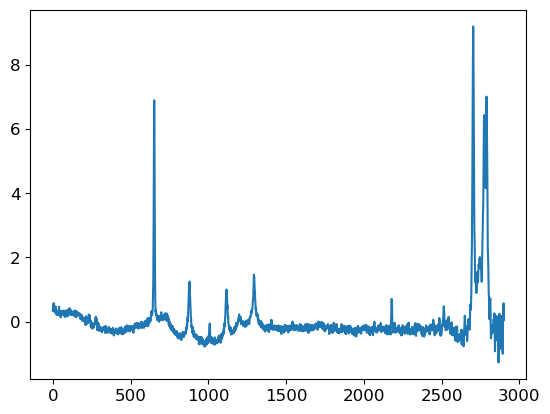

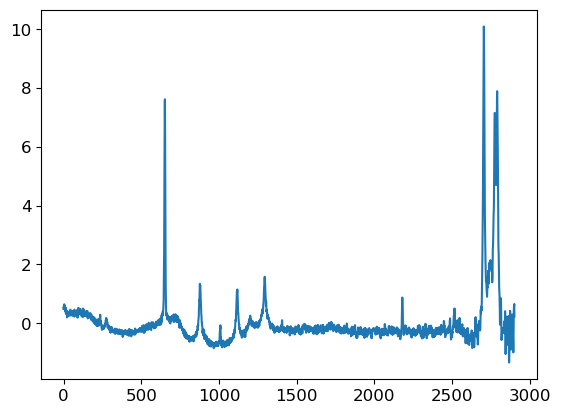

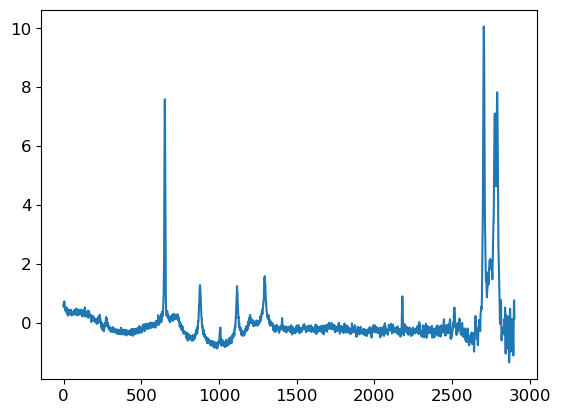

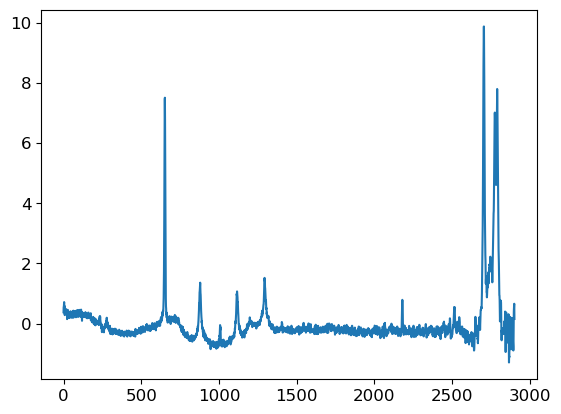

Epoch:[201/1000] 	Average Epoch Loss: 0.0078
Epoch:[202/1000] 	Average Epoch Loss: 0.0089
Epoch:[203/1000] 	Average Epoch Loss: 0.0088
Epoch:[204/1000] 	Average Epoch Loss: 0.0089
Epoch:[205/1000] 	Average Epoch Loss: 0.0077
Epoch:[206/1000] 	Average Epoch Loss: 0.0083
Epoch:[207/1000] 	Average Epoch Loss: 0.0084
Epoch:[208/1000] 	Average Epoch Loss: 0.0074
Epoch:[209/1000] 	Average Epoch Loss: 0.0083
Epoch:[210/1000] 	Average Epoch Loss: 0.0074
Epoch:[211/1000] 	Average Epoch Loss: 0.0089
Epoch:[212/1000] 	Average Epoch Loss: 0.0082
Epoch:[213/1000] 	Average Epoch Loss: 0.0082
Epoch:[214/1000] 	Average Epoch Loss: 0.0080
Epoch:[215/1000] 	Average Epoch Loss: 0.0084
Epoch:[216/1000] 	Average Epoch Loss: 0.0071
Epoch:[217/1000] 	Average Epoch Loss: 0.0074
Epoch:[218/1000] 	Average Epoch Loss: 0.0079
Epoch:[219/1000] 	Average Epoch Loss: 0.0080
Epoch:[220/1000] 	Average Epoch Loss: 0.0078
Epoch:[221/1000] 	Average Epoch Loss: 0.0085
Epoch:[222/1000] 	Average Epoch Loss: 0.0077
Epoch:[223

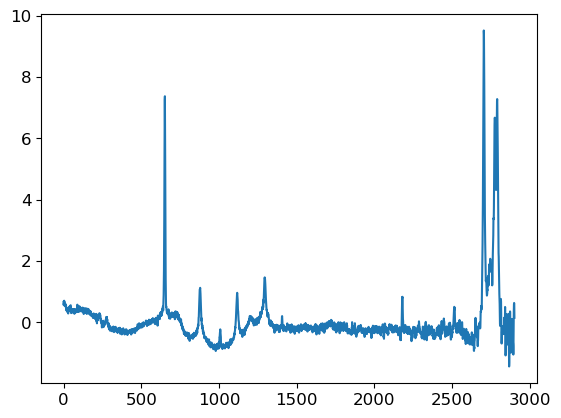

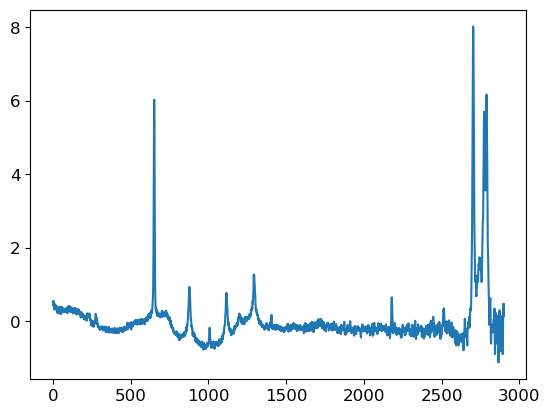

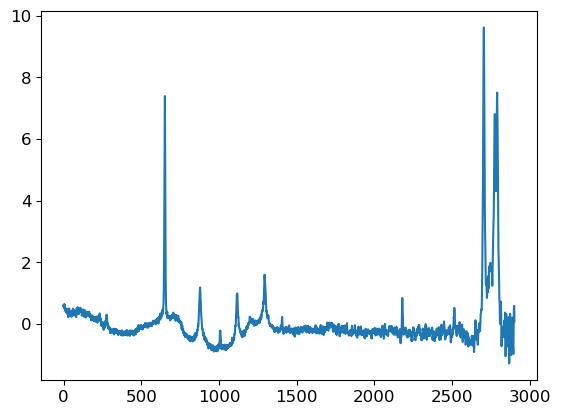

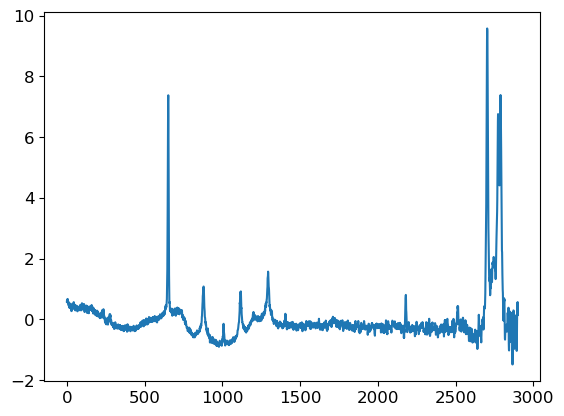

Epoch:[401/1000] 	Average Epoch Loss: 0.0079
Epoch:[402/1000] 	Average Epoch Loss: 0.0083
Epoch:[403/1000] 	Average Epoch Loss: 0.0073
Epoch:[404/1000] 	Average Epoch Loss: 0.0076
Epoch:[405/1000] 	Average Epoch Loss: 0.0074
Epoch:[406/1000] 	Average Epoch Loss: 0.0079
Epoch:[407/1000] 	Average Epoch Loss: 0.0081
Epoch:[408/1000] 	Average Epoch Loss: 0.0089
Epoch:[409/1000] 	Average Epoch Loss: 0.0075
Epoch:[410/1000] 	Average Epoch Loss: 0.0078
Epoch:[411/1000] 	Average Epoch Loss: 0.0087
Epoch:[412/1000] 	Average Epoch Loss: 0.0086
Epoch:[413/1000] 	Average Epoch Loss: 0.0081
Epoch:[414/1000] 	Average Epoch Loss: 0.0080
Epoch:[415/1000] 	Average Epoch Loss: 0.0080
Epoch:[416/1000] 	Average Epoch Loss: 0.0088
Epoch:[417/1000] 	Average Epoch Loss: 0.0075
Epoch:[418/1000] 	Average Epoch Loss: 0.0081
Epoch:[419/1000] 	Average Epoch Loss: 0.0078
Epoch:[420/1000] 	Average Epoch Loss: 0.0073
Epoch:[421/1000] 	Average Epoch Loss: 0.0078
Epoch:[422/1000] 	Average Epoch Loss: 0.0081
Epoch:[423

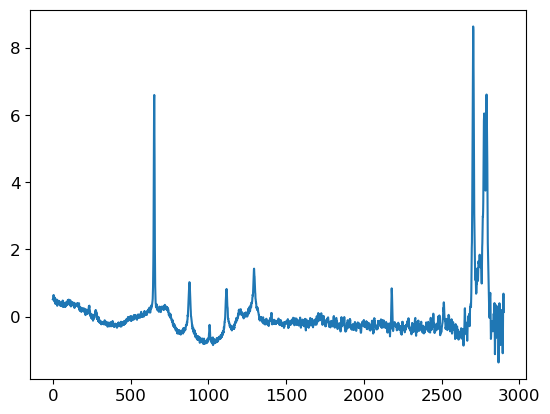

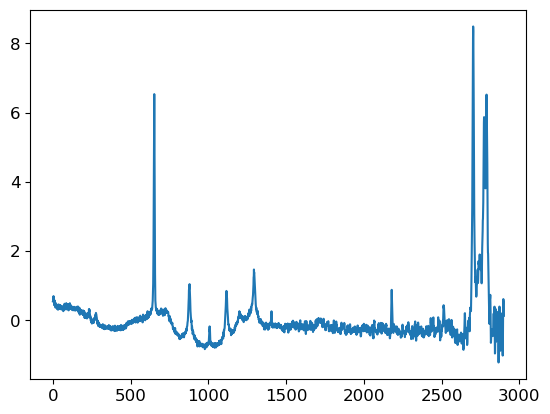

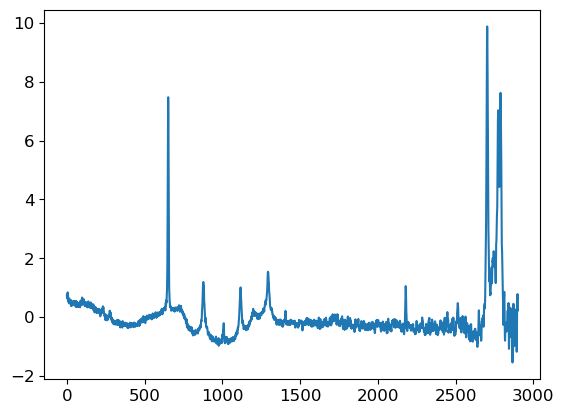

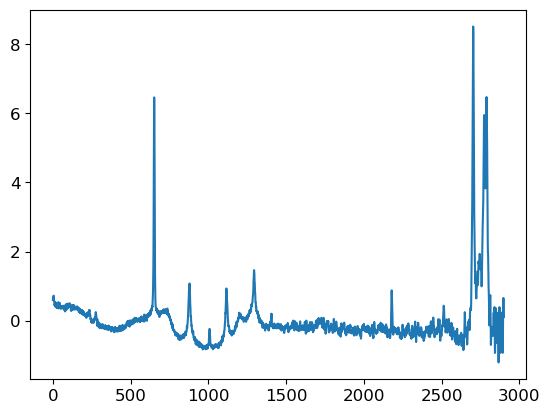

Epoch:[601/1000] 	Average Epoch Loss: 0.0081
Epoch:[602/1000] 	Average Epoch Loss: 0.0077
Epoch:[603/1000] 	Average Epoch Loss: 0.0084
Epoch:[604/1000] 	Average Epoch Loss: 0.0084
Epoch:[605/1000] 	Average Epoch Loss: 0.0081
Epoch:[606/1000] 	Average Epoch Loss: 0.0074
Epoch:[607/1000] 	Average Epoch Loss: 0.0080
Epoch:[608/1000] 	Average Epoch Loss: 0.0081
Epoch:[609/1000] 	Average Epoch Loss: 0.0077
Epoch:[610/1000] 	Average Epoch Loss: 0.0093
Epoch:[611/1000] 	Average Epoch Loss: 0.0074
Epoch:[612/1000] 	Average Epoch Loss: 0.0073
Epoch:[613/1000] 	Average Epoch Loss: 0.0078
Epoch:[614/1000] 	Average Epoch Loss: 0.0081
Epoch:[615/1000] 	Average Epoch Loss: 0.0086
Epoch:[616/1000] 	Average Epoch Loss: 0.0089
Epoch:[617/1000] 	Average Epoch Loss: 0.0077
Epoch:[618/1000] 	Average Epoch Loss: 0.0083
Epoch:[619/1000] 	Average Epoch Loss: 0.0079
Epoch:[620/1000] 	Average Epoch Loss: 0.0085
Epoch:[621/1000] 	Average Epoch Loss: 0.0072
Epoch:[622/1000] 	Average Epoch Loss: 0.0073
Epoch:[623

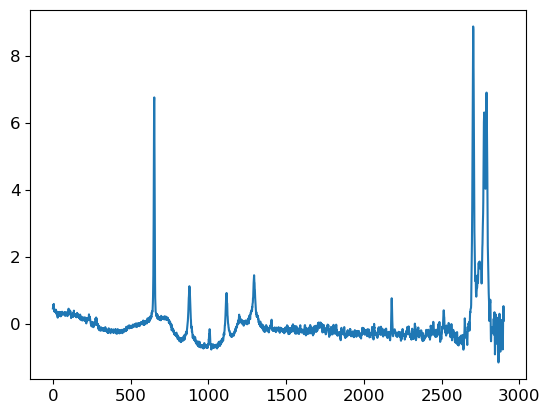

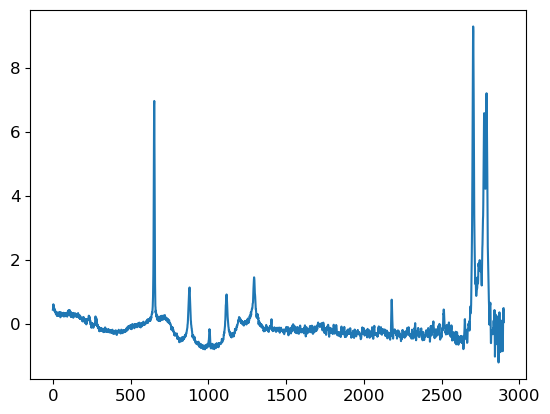

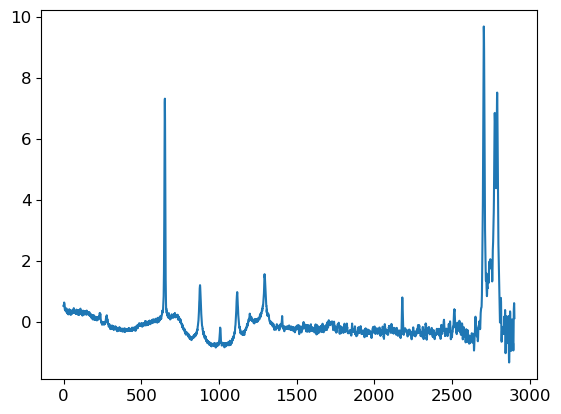

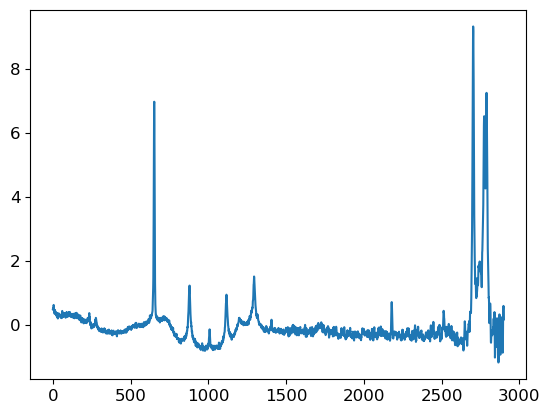

Epoch:[801/1000] 	Average Epoch Loss: 0.0079
Epoch:[802/1000] 	Average Epoch Loss: 0.0076
Epoch:[803/1000] 	Average Epoch Loss: 0.0080
Epoch:[804/1000] 	Average Epoch Loss: 0.0073
Epoch:[805/1000] 	Average Epoch Loss: 0.0077
Epoch:[806/1000] 	Average Epoch Loss: 0.0074
Epoch:[807/1000] 	Average Epoch Loss: 0.0074
Epoch:[808/1000] 	Average Epoch Loss: 0.0085
Epoch:[809/1000] 	Average Epoch Loss: 0.0077
Epoch:[810/1000] 	Average Epoch Loss: 0.0071
Epoch:[811/1000] 	Average Epoch Loss: 0.0083
Epoch:[812/1000] 	Average Epoch Loss: 0.0084
Epoch:[813/1000] 	Average Epoch Loss: 0.0074
Epoch:[814/1000] 	Average Epoch Loss: 0.0074
Epoch:[815/1000] 	Average Epoch Loss: 0.0070
Epoch:[816/1000] 	Average Epoch Loss: 0.0086
Epoch:[817/1000] 	Average Epoch Loss: 0.0077
Epoch:[818/1000] 	Average Epoch Loss: 0.0083
Epoch:[819/1000] 	Average Epoch Loss: 0.0078
Epoch:[820/1000] 	Average Epoch Loss: 0.0072
Epoch:[821/1000] 	Average Epoch Loss: 0.0077
Epoch:[822/1000] 	Average Epoch Loss: 0.0084
Epoch:[823

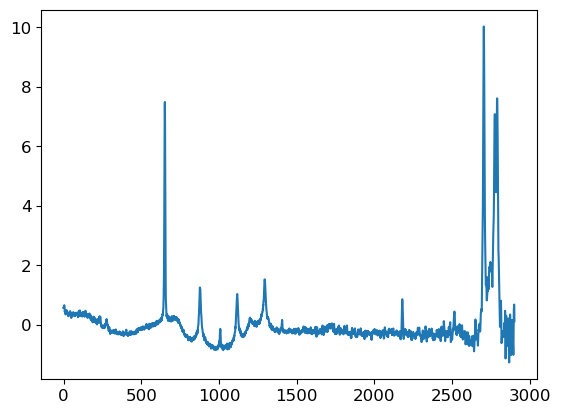

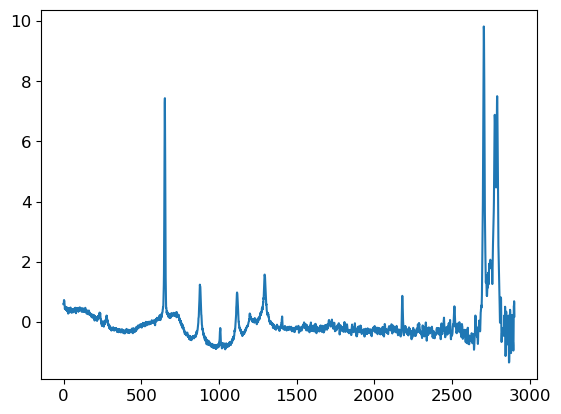

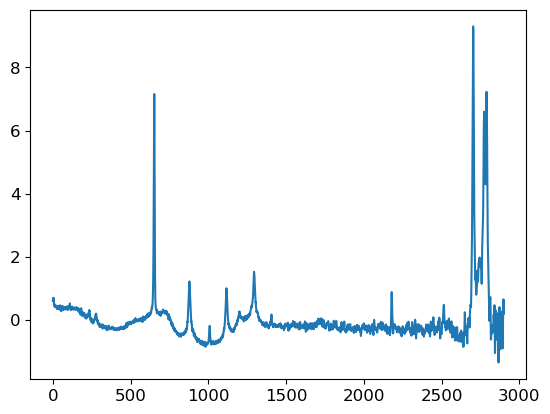

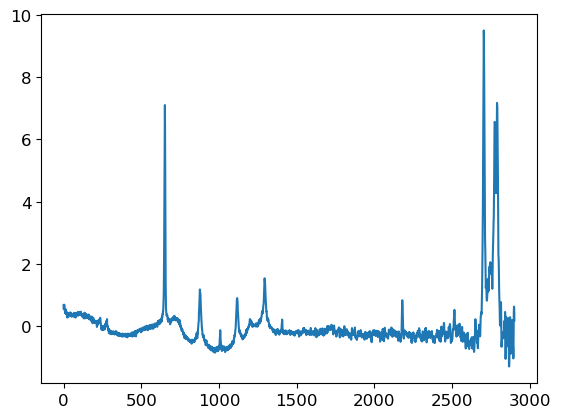

VAE training took approx: 0.3314 minutes


In [9]:
# track training time
start_time = time.time()

epoch_losses = []
average_epoch_losses = []

# Define training loop
for epoch in range(EPOCHS):
    # tell Torch we are going to start training (required if we execute eval() to visualise samples during training)
    model.train()
    
    epoch_loss = 0
    for batch_idx, batch in enumerate(train_loader):
        batch = batch.to(DEVICE)
        
        # reset optimiser each iteration
        optimiser.zero_grad() 

        # feed sample and reconstruct
        x_hat, mean, logvar = model(batch)
       
        loss = loss_function(batch, x_hat, mean, logvar)
        
        # track loss for each iteration
        epoch_loss += loss.item()
        
        # calculate gradients and update model
        loss.backward()
        optimiser.step()
        
    # Training stats  
    average_epoch_loss = epoch_loss / len(train_loader)    
    print(f'Epoch:[{epoch + 1}/{EPOCHS}] \tAverage Epoch Loss: {average_epoch_loss:.4f}')

    average_epoch_losses.append(average_epoch_loss)
    epoch_losses.append(epoch_loss)
    
    # Draw some samples
    if (epoch + 1) % 200 == 0:
        draw_synthetic_sample(model.decoder, epoch + 1, SAMPLE_SHAPE)

print(f"VAE training took approx: {round((time.time() - start_time) / 60, 4)} minutes")

# Plot losses

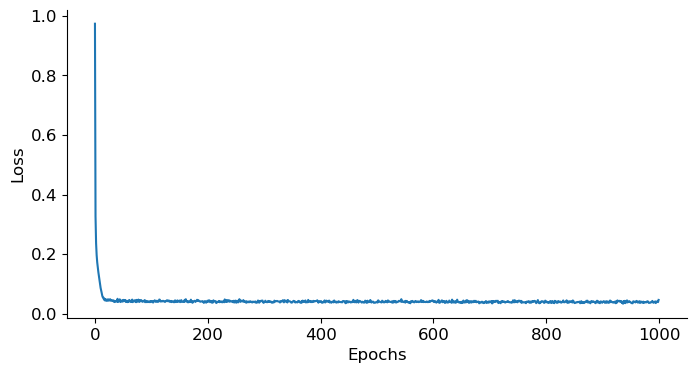

In [10]:
fig, ax = plt.subplots(figsize=(8, 4))
plt.gca().spines['right'].set_color('none')
plt.gca().spines['top'].set_color('none')
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.grid(False)
plt.plot(epoch_losses)

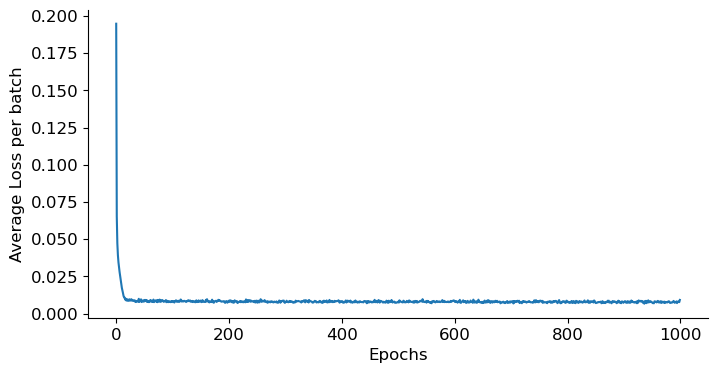

In [11]:
fig, ax = plt.subplots(figsize=(8, 4))
plt.gca().spines['right'].set_color('none')
plt.gca().spines['top'].set_color('none')
plt.ylabel("Average Loss per batch")
plt.xlabel("Epochs")
plt.grid(False)
plt.plot(average_epoch_losses)

# Save model to disk


In [12]:
decoder_path = "models/vae_decoder_preprocessed.pth"
torch.save(model.decoder.state_dict(), decoder_path)

# Load model from disk

In [13]:
# define new model
decoder = Decoder(LATENT_DIM, SAMPLE_SHAPE)

# Load the saved weights
decoder.load_state_dict(torch.load(decoder_path))
decoder.to(DEVICE)
decoder.eval()

# Generate some samples
noise = torch.randn(145, LATENT_DIM, device=DEVICE).detach()
synthetic_samples = decoder(noise).detach().cpu().numpy()

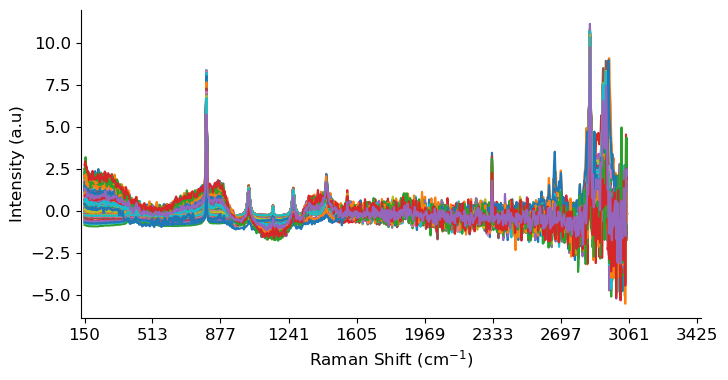

In [14]:
# Original spectra
_ = build_plot()
plt.plot(X_scaled.T);

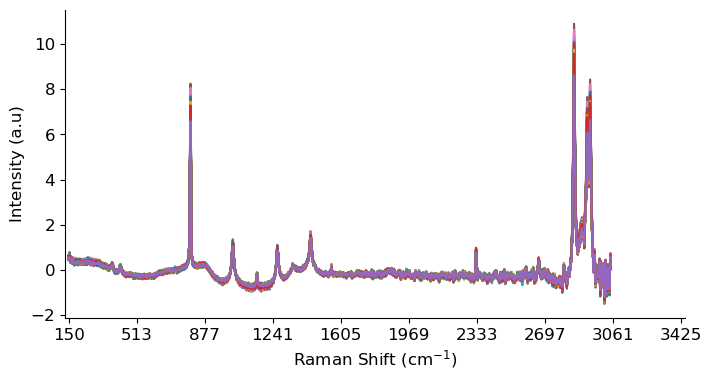

In [15]:
# New Synthetic spectra
_ = build_plot()
plt.plot(synthetic_samples.T);